<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# ResNet50 with Weight Stripping

NVIDIA® [TensorRT](https://developer.nvidia.com/tensorrt)™ is an SDK designed for high-performance deep learning inference. TensorRT acts as an Ahead-of-Time (AoT) compiler, which necessitates the offline generation of an engine plan file. This file contains optimized backend kernels tailored for the production environment, with both the kernel code and weights embedded within it. 

For Independent Software Vendors (ISVs) deploying these engine plan files, it is crucial to have one engine file per SKU to achieve optimal performance. When there are N SKUs, the weights are duplicated N times, significantly increasing the installer size. This is particularly problematic for the Windows platform, which has over 40 consumer SKUs. 

To address this issue, we introduced the weight stripping feature in TensorRT 10.0. With weight stripping enabled, TensorRT creates a refittable engine based on the assumption that the refit weights will be identical to those provided during the build. The resulting engine maintains the same performance as a non-refittable one. All refittable weights can be adjusted through the refit API. Moreover, by stripping all the refittable weights, we produce a small plan file, with weights supplied later via refitting. This approach allows the use of a single set of weights across different inference backends or TensorRT plans for multiple GPU architectures. 

This notebook demonstrates how to use TensorRT to build a weight-stripped engine and later refit it to a full engine for inference, using ResNet-50 as an example.

## Content
1. [Download model and install pre-requisites](#1)
2. [Building a full TensorRT engine](#2)
3. [Building a weight-stripped TensorRT engine](#3)
4. [Running inference example using the full engine](#4)
5. [Running inference example using the weight-stripped engine](#5)
6. [Serialize the refitted weight-stripped engine (optional)](#6)
7. [Inference benchmarking](#7)
8. [Engine plan size comparison](#8)
9. [Advanced topic: weight-stripping with lean runtime](#9)

<a id="1"></a>

## 1. Download model and install pre-requisites

### Download model and dataset

First, let's download the ResNet50 ONNX model and test image from TensorRT installer package.

In [1]:
!wget https://download.onnxruntime.ai/onnx/models/resnet50.tar.gz -O resnet50.tar.gz
!tar -xzf resnet50.tar.gz

!wget https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/10.0.1/tars/TensorRT-10.0.1.6.Linux.x86_64-gnu.cuda-12.4.tar.gz
!tar -xzf TensorRT-10.0.1.6.Linux.x86_64-gnu.cuda-12.4.tar.gz TensorRT-10.0.1.6/data/int8_api/reference_labels.txt TensorRT-10.0.1.6/data/int8_api/airliner.ppm TensorRT-10.0.1.6/targets/x86_64-linux-gnu/lib/libnvinfer_lean.so.10.0.1
!mv TensorRT-10.0.1.6/data/int8_api/airliner.ppm  .
!mv TensorRT-10.0.1.6/data/int8_api/reference_labels.txt  .
!mv TensorRT-10.0.1.6/targets/x86_64-linux-gnu/lib/libnvinfer_lean.so.10.0.1 .
!rm -rf TensorRT-10.0.1.6 TensorRT-10.0.1.6.Linux.x86_64-gnu.cuda-12.4.tar.gz

--2024-05-24 22:19:02--  https://download.onnxruntime.ai/onnx/models/resnet50.tar.gz
Resolving download.onnxruntime.ai (download.onnxruntime.ai)... 13.107.246.71, 2620:1ec:bdf::71
Connecting to download.onnxruntime.ai (download.onnxruntime.ai)|13.107.246.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101632129 (97M) [application/octet-stream]
Saving to: ‘resnet50.tar.gz’

resnet50.tar.gz     100%[===================>]  96.92M  7.59MB/s    in 14s     

2024-05-24 22:19:16 (6.97 MB/s) - ‘resnet50.tar.gz’ saved [101632129/101632129]

--2024-05-24 22:19:20--  https://developer.nvidia.com/downloads/compute/machine-learning/tensorrt/10.0.1/tars/TensorRT-10.0.1.6.Linux.x86_64-gnu.cuda-12.4.tar.gz
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/m

### Install pre-requisites

The Python sample is built on top of the native TensorRT API. To streamline the code and enhance its readability, we use polygraphy in the notebook. We also use matpoltlib to visualize the data. Therefore, it's necessary to install polygraphy and matplotlib.

In [2]:
%pip install --upgrade --force-reinstall tensorrt==10.0.1
%pip install -q --upgrade --force-reinstall matplotlib colored polygraphy>=0.49.9 --extra-index-url https://pypi.ngc.nvidia.com;

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


⚠️ <span style="color:red"> **Make sure to restart the kernels before continuing to check that the installed version of TensorRT is 10.0.1+ and Polygraphy is 0.49.9+.** </span>

In [1]:
import sys
import site
sys.path.append(site.getusersitepackages())

import polygraphy
import tensorrt
print(f"polygraphy version {polygraphy.__version__}")
print(f"tensorrt version {tensorrt.__version__}")

polygraphy version 0.49.9
tensorrt version 10.0.1


<a id="2"></a>

## 2. Building a full TensorRT engine

In this section, we will optimize the ResNet model for inference with FP16 enabled. The final engine will be saved to the local disk for subsequent engine plan size comparisons.

In [2]:
from polygraphy.backend.trt import CreateConfig, network_from_onnx_path, engine_from_network, save_engine

# Create FP16 TensorRT engine from onnx model.
network = network_from_onnx_path('resnet50/model.onnx')
config = CreateConfig(fp16=True)
engine = engine_from_network(network, config)
save_engine(engine, path='resnet50_full.plan')

[I] Configuring with profiles:[
        Profile 0:
            {gpu_0/data_0 [min=[1, 3, 224, 224], opt=[1, 3, 224, 224], max=[1, 3, 224, 224]]}
    ]
[W] profileSharing0806 is on by default in TensorRT 10.0. This flag is deprecated and has no effect.
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 40326.38 MiB, TACTIC_DRAM: 40326.38 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 37.975 seconds
[I] Saving engine to resnet50_full.plan


<a id="3"></a>

## 3. Building a weight-stripped TensorRT engine

To enable weight stripping, simply set the strip_plan flag in the builder configuration. This requires only one line of code modification as shown below:

In [3]:
# Create FP16 TensorRT engine from onnx model with weight-stripped.
config = CreateConfig(fp16=True, strip_plan=True)
engine = engine_from_network(network, config)
save_engine(engine, path='resnet50_stripped.plan')

[I] Configuring with profiles:[
        Profile 0:
            {gpu_0/data_0 [min=[1, 3, 224, 224], opt=[1, 3, 224, 224], max=[1, 3, 224, 224]]}
    ]
[I] Building engine with configuration:
    Flags                  | [FP16, WEIGHTLESS, STRIP_PLAN]
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 40326.38 MiB, TACTIC_DRAM: 40326.38 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 34.358 seconds
[I] Saving engine to resnet50_stripped.plan


<a id="4"></a>

## 4. Running inference example using the full engine

In this section, we will use an airliner image to verify the inference results on both engines.

### Prepare input data
Let's use pillow to load the image and load the reference labels from a text file.

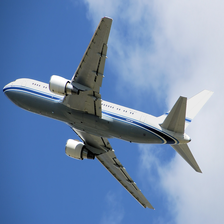

In [4]:
from PIL import Image
import numpy as np
from IPython.display import display

# Load the image.
image_path = 'airliner.ppm'
img = Image.open(image_path)

# Display the image.
display(img)

# Transpose to NCHW layout and normalize data.
img = np.transpose(img, (2, 0, 1))  
img = np.array(img).astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0)

# Load labels
labels = open('reference_labels.txt', "r").read().split("\n")

### Load full TensorRT engine

In [5]:
import tensorrt as trt
from polygraphy.backend.common import bytes_from_path
from polygraphy.backend.trt import engine_from_bytes

# Load TensorRT engine from plan file.
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
full_engine = engine_from_bytes(bytes_from_path('resnet50_full.plan'))


[I] Loading bytes from resnet50_full.plan


### Inference with full engine
Let's verify that TensorRT can recognize this image as 'airliner'.

In [6]:
from polygraphy.backend.trt import TrtRunner

# Inference and get the result.
with TrtRunner(full_engine) as runner:
    outputs = runner.infer(feed_dict={"gpu_0/data_0": img})

pred = labels[np.argmax(outputs['gpu_0/softmax_1'])]
print(f"Full engine recognize image as '{pred}'!")

Full engine recognize image as 'airliner'!


<a id="5"></a>

## 5. Running inference example using the weight-stripped engine

Now, we will perform inference again using the weight-stripped engine. Let's skip the input data preparation step since it's the same as the full engine inference, and jump straight to loading the engine.

### Load weight-stripped engine and update weights
Note that this time, all the weights are stripped in the engine. We cannot directly use this engine for inference; instead, we need to pull the weights back using the refit API first. Since the engine was built using an ONNX model, we can use the OnnxParserRefitter class provided by TensorRT to automate the refit.

In [7]:
# Load TensorRT engine from plan file.
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
stripped_engine = engine_from_bytes(bytes_from_path('resnet50_stripped.plan'))

# Update weights using refit API.
refitter = trt.Refitter(stripped_engine, TRT_LOGGER)
parser_refitter = trt.OnnxParserRefitter(refitter, TRT_LOGGER)
parser_refitter.refit_from_file('resnet50/model.onnx')
refitter.refit_cuda_engine()

[I] Loading bytes from resnet50_stripped.plan


True

### Inference with refitted weight-stripped engine
Let's verify that TensorRT can still recognize this image as 'airliner' on the refitted weight-stripped engine.

In [8]:
# Inference and get the result.
with TrtRunner(stripped_engine) as runner:
    outputs = runner.infer(feed_dict={"gpu_0/data_0": img})

pred = labels[np.argmax(outputs['gpu_0/softmax_1'])]
print(f"Refitted stripped engine recognize image as '{pred}'!")

Refitted stripped engine recognize image as 'airliner'!


<a id="6"></a>

## 6. Serialize the refitted weight-stripped engine (optional) 
We can save the refitted, weight-stripped engine to disk, so you won't need to refit it next time you run inference.

In [9]:
# Create config that include weights in plan.
s_config = stripped_engine.create_serialization_config()
s_config.flags &= ~(1 << int(trt.SerializationFlag.EXCLUDE_WEIGHTS))

# Serialize the plan file.
full_binary = engine.serialize_with_config(s_config)
with open('resnet50_stripped_updated.plan', 'wb') as f:
    f.write(full_binary)

<a id="7"></a>

## 7. Inference benchmarking
We have just finished verifying the accuracy. Now, let's measure the performance between the full engine and the weight-stripped engine.

### Benchmarking a full engine
First, let's check the total time of 100 iterations on the full engine.

In [10]:
import time

# Inference for 100 iterations.
start_time = time.time()
with TrtRunner(full_engine) as runner:
    for i in range(100):
        outputs = runner.infer(feed_dict={"gpu_0/data_0": img})
total_time_full = time.time() - start_time
print("Full engine inference time on 100 iterations: {:.4f} seconds".format(total_time_full))

Full engine inference time on 100 iterations: 0.2797 seconds


### Benchmarking a weight-stripped engine
Again, let's use the same code to check the 100 iterations on the weight-stripped engine.

In [11]:
# Inference for 100 iterations.
start_time = time.time()
with TrtRunner(stripped_engine) as runner:
    for i in range(100):
        outputs = runner.infer(feed_dict={"gpu_0/data_0": img})
total_time_stripped = time.time() - start_time
print("Refitted stripped engine inference time on 100 iterations: {:.4f} seconds".format(total_time_stripped))

Refitted stripped engine inference time on 100 iterations: 0.2845 seconds


Let's do a comparison, but let's ignore the small variances due to using the floating clock. We can see that there is no performance difference between the full engine and the weight-stripped engine!

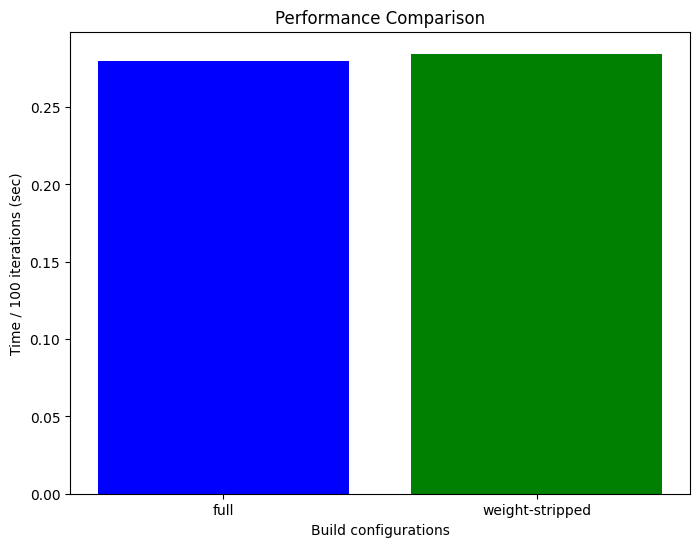

In [12]:
import matplotlib.pyplot as plt

# Plot the inference time comparison.
plt.figure(figsize=(8, 6))
plt.bar(['full', 'weight-stripped'], [total_time_full, total_time_stripped], color=['blue', 'green'])
plt.xlabel('Build configurations')
plt.ylabel('Time / 100 iterations (sec)')
plt.title('Performance Comparison')
plt.show()

<a id="8"></a>

## 8. Engine plan size comparison
So far, we have verified that we did not lose performance or accuracy for the weight-stripped engine. Now, let's check the engine file size. With simple math, we can see that we reduced 95% of the original engine size. Considering deployment on N SKUs, we will save 95% on each SKU. This will greatly help with the TensorRT integration into your own project.

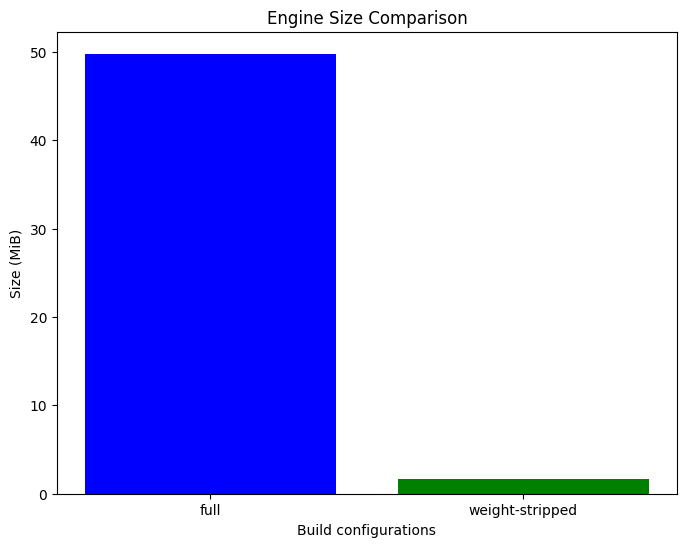

In [13]:
import os 

# Get the file sizes in MiB
full_size = os.path.getsize('resnet50_full.plan') / 1024 / 1024
stripped_size = os.path.getsize('resnet50_stripped.plan') / 1024 / 1024

# Plot the engine size comparison.
plt.figure(figsize=(8, 6))
plt.bar(['full', 'weight-stripped'], [full_size, stripped_size], color=['blue', 'green'])
plt.xlabel('Build configurations')
plt.ylabel('Size (MiB)')
plt.title('Engine Size Comparison')
plt.show()

<a id="9"></a>

## 9. Advanced topic: weight-stripping with lean runtime


Additionally, we can leverage the lean runtime to further reduce the package size for the weight-stripped engine. The lean runtime is the same runtime used in version-compatible engines. Originally designed to enable users to generate a TensorRT engine with version X and load it with an application built with version Y, the lean runtime library is relatively small, approximately 40 MiB. Therefore, software distributors on top of TensorRT only need to ship the weight-stripped engine along with the 40 MiB lean runtime when the weights are already available on the target customer machine.

### Build with version compatible
This can be achieved with as little as one line change to the builder code.

In [14]:
# Build TensorRT full engine with version compatible.
config = CreateConfig(fp16=True, version_compatible=True, exclude_lean_runtime=True)
engine = engine_from_network(network, config)
save_engine(engine, path='resnet50_full_vc.plan')

[I] Configuring with profiles:[
        Profile 0:
            {gpu_0/data_0 [min=[1, 3, 224, 224], opt=[1, 3, 224, 224], max=[1, 3, 224, 224]]}
    ]
[I] Version or hardware compatibility was enabled. If you are using an ONNX model, please set the NATIVE_INSTANCENORM ONNX parser flag, e.g. `--onnx-flags NATIVE_INSTANCENORM`
[I] Building engine with configuration:
    Flags                  | [FP16, VERSION_COMPATIBLE, EXCLUDE_LEAN_RUNTIME]
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 40326.38 MiB, TACTIC_DRAM: 40326.38 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 35.676 seconds
[I] Saving engine to resnet50_full_vc.plan


### Build with both weight-stripped and version compatible
This can also be accomplished with just a single line change to the builder code.

In [15]:
# Build TensorRT weight-stripped engine with version compatible.
config = CreateConfig(fp16=True, strip_plan=True, version_compatible=True, exclude_lean_runtime=True)
engine = engine_from_network(network, config)
save_engine(engine, path='resnet50_stripped_vc.plan')

[I] Configuring with profiles:[
        Profile 0:
            {gpu_0/data_0 [min=[1, 3, 224, 224], opt=[1, 3, 224, 224], max=[1, 3, 224, 224]]}
    ]
[I] Version or hardware compatibility was enabled. If you are using an ONNX model, please set the NATIVE_INSTANCENORM ONNX parser flag, e.g. `--onnx-flags NATIVE_INSTANCENORM`
[I] Building engine with configuration:
    Flags                  | [FP16, VERSION_COMPATIBLE, EXCLUDE_LEAN_RUNTIME, WEIGHTLESS, STRIP_PLAN]
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 40326.38 MiB, TACTIC_DRAM: 40326.38 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 44.720 seconds
[I] Saving engine to resnet50_stripped_vc.plan


### Load weight-stripped engine with lean runtime

The dispatch runtime and lean runtime are the dependency libraries you need to ship with your software. Here, the dispatch runtime serves as a shim library, forwarding API calls to the lean runtime. Meanwhile, the lean runtime contains both the host code and device code necessary to launch your inference job.


In [17]:
from polygraphy.backend.trt import load_runtime

# Load the weight-stripped engine using lean runtime.
lean_runtime = load_runtime('./libnvinfer_lean.so.10.0.1')
stripped_vc_engine = engine_from_bytes(bytes_from_path('resnet50_stripped_vc.plan'), runtime=lean_runtime)

[I] Loading TensorRT runtime from: ./libnvinfer_lean.so.10.0.1
[I] Loading bytes from resnet50_stripped_vc.plan


### Update weights using refit API

We still use the same refit API to update the weights loaded from the lean runtime.

In [18]:
# Update the weight-stripped engine using refit API.
refitter = trt.Refitter(stripped_vc_engine, TRT_LOGGER)
parser_refitter = trt.OnnxParserRefitter(refitter, TRT_LOGGER)
parser_refitter.refit_from_file('resnet50/model.onnx')
refitter.refit_cuda_engine()

True

### Inference with airliner image
Now it is time to verify the result!

In [19]:
# Inference and get the result.
with TrtRunner(stripped_vc_engine) as runner:
    outputs = runner.infer(feed_dict={"gpu_0/data_0": img})

pred = labels[np.argmax(outputs['gpu_0/softmax_1'])]
print(f"Refitted stripped VC engine recognize image as '{pred}'!")

Refitted stripped VC engine recognize image as 'airliner'!


### Size comparison of different deployment solution
Finally let's compare the four solutions here:
- Full engine + full runtime
- Weight-stripped engine + full runtime
- Full engine + lean runtime + dispatch runtime
- Weight-stripped engine + lean runtime + dispatch runtime

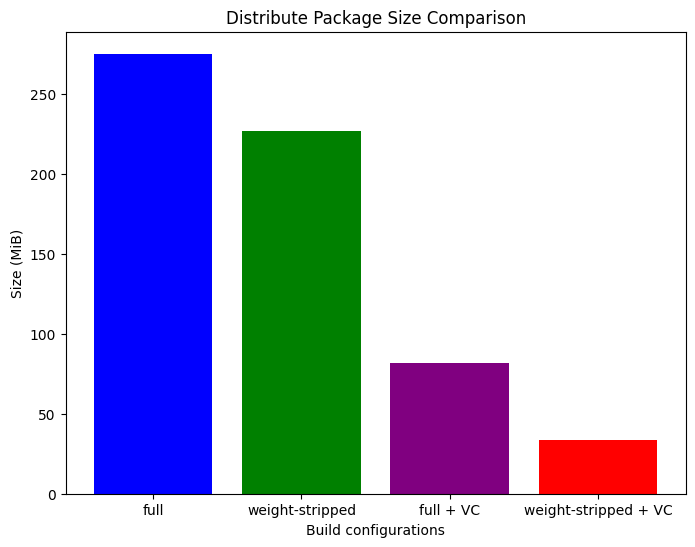

In [20]:
# Get the library sizes in MiB.
full_runtime_size = os.path.getsize(os.path.realpath('/usr/lib/x86_64-linux-gnu/libnvinfer.so')) / 1024 / 1024
lean_runtime_size = os.path.getsize(os.path.realpath('/usr/lib/x86_64-linux-gnu/libnvinfer_lean.so')) / 1024 / 1024
dispatch_runtime_size = os.path.getsize(os.path.realpath('/usr/lib/x86_64-linux-gnu/libnvinfer_dispatch.so')) / 1024 / 1024

# Get the library + engine file sizes in MiB.
full_size = full_runtime_size + os.path.getsize('resnet50_full.plan') / 1024 / 1024
stripped_size = full_runtime_size + os.path.getsize('resnet50_stripped.plan') / 1024 / 1024
full_vc_size = lean_runtime_size + dispatch_runtime_size + os.path.getsize('resnet50_full_vc.plan') / 1024 / 1024
stripped_vc_size = lean_runtime_size + dispatch_runtime_size + os.path.getsize('resnet50_stripped.plan') / 1024 / 1024

# Plot the distribution size comparison.
plt.figure(figsize=(8, 6))
plt.bar(['full', 'weight-stripped', 'full + VC', 'weight-stripped + VC'], [full_size, stripped_size, full_vc_size, stripped_vc_size], color=['blue', 'green', 'purple', 'red'])
plt.xlabel('Build configurations')
plt.ylabel('Size (MiB)')
plt.title('Distribute Package Size Comparison')
plt.show()